In [1]:
# Read in Libraries
from __future__ import division, print_function
from logbook import Logger, StreamHandler
import sys
StreamHandler(sys.stdout).push_application()
log = Logger('Logbook')
import shutil, csv, time
timestr = time.strftime("%Y%m%d")
import ujson as json
import utils; reload(utils)
from utils import *
import gc
# from __future__ import division, print_function
from theano.sandbox import cuda
from vgg16bn import Vgg16BN
from sklearn import metrics
%matplotlib inline

def accuracyfunc(y_act, y_pred):
    return metrics.accuracy_score(np.argmax(y_act, axis=1), np.argmax(y_pred, axis=1))
    
def refresh_directory_structure(name, sub_dirs):
    gdir = os.path.join(path, name)
    if os.path.exists(gdir):
        shutil.rmtree(gdir)
    os.makedirs(gdir)
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(gdir, sub_dir))


Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
# Set Parameters and check files
refresh_directories = False
input_exists = True
full = True
log.info('Set Paramters')
path = "../data/fish/"
batch_size=32
clip = 0.99
bags = 1
load_size = (440, 780)#(360, 640)

[2017-02-18 22:33:12.277079] INFO: Logbook: Set Paramters


In [3]:
# Create the test and valid directory
if refresh_directories:
    log.info('Create directory structure and validation files')
    sub_dirs = os.listdir(os.path.join(path, 'train-all'))
    if '.DS_Store' in sub_dirs: sub_dirs.remove('.DS_Store')
    refresh_directory_structure('train', sub_dirs)
    refresh_directory_structure('valid', sub_dirs)
    for c,row in enumerate(csv.DictReader(open('../image_validation_set.csv'))):
        value = 'valid' if row['Validation'] == '1' else 'train'
        name_from = os.path.join(path, 'train-all', row['SubDirectory'], row['file_name'])
        name_to   = os.path.join(path, value, row['SubDirectory'], row['file_name'])
        shutil.copyfile(name_from, name_to)
        

In [4]:
# Read in our VGG pretrained model
log.info('Get VGG')
model = vgg_ft_bn(8)

# Create our VGG model
log.info('Create VGG')
vgg640 = Vgg16BN(load_size).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

# get labels
(val_classes, trn_classes, val_labels, trn_labels,
    val_filenames, filenames, test_filenames) = get_classes(path)

# Read in filenames
log.info('Read filenames')
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

[2017-02-18 22:33:12.301056] INFO: Logbook: Get VGG
[2017-02-18 22:33:15.466100] INFO: Logbook: Create VGG
Found 3086 images belonging to 8 classes.
Found 691 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.
[2017-02-18 22:33:16.093835] INFO: Logbook: Read filenames


In [5]:
# Read in the boxes
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']
bb_json = {}
for c in anno_classes:
    j = json.load(open(os.path.join(path, 'box/{}_labels.json'.format(c)), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

# make it easy to find the nof dots, by putting themin the middle
#empty_bbox = {'height': 0., 'width': 0., 'x': 1280/2., 'y': 720/2}
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [6]:
# Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (load_size[1] / size[0])#(224. / size[0])
    conv_y = (load_size[0] / size[1])#(224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [7]:
trn_sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
tst_sizes = [PIL.Image.open(path+'test/'+f).size for f in test_filenames]

In [8]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, trn_sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, val_sizes)]).astype(np.float32)

Found 691 images belonging to 8 classes.


1906

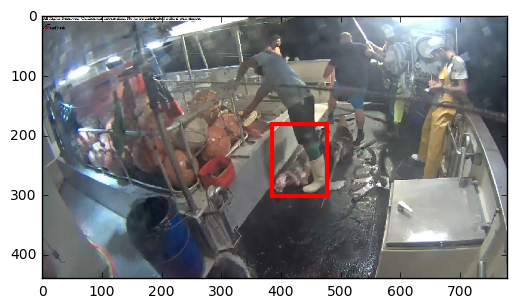

In [9]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

val = get_data(path+'valid', load_size)
show_bb(500)
del val
gc.collect()

In [10]:
log.info('Read in data')
if not input_exists:

    batches = get_batches(path+'train', batch_size=batch_size)
    val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
    (val_classes, trn_classes, val_labels, trn_labels, 
        val_filenames, filenames, test_filenames) = get_classes(path)
    
    # Fetch our large images 
    # Precompute the output of the convolutional part of VGG
    log.info('Fetch images')
    log.info('Get VGG output')
    log.info('Write VGG output')
    
    val = get_data(path+'valid', load_size)
    conv_val_feat = vgg640.predict(val, batch_size=16, verbose=1)
    save_array(path+'results/conv_val_big_feat.dat', conv_val_feat)
    del val, conv_val_feat
    gc.collect()
    
    trn = get_data(path+'train', load_size)
    conv_trn_feat = vgg640.predict(trn, batch_size=16, verbose=1)    
    del trn
    gc.collect()
    save_array(path+'results/conv_trn_big_feat.dat', conv_trn_feat) 
    del conv_trn_feat
    gc.collect()
    
    test = get_data(path+'test', load_size)
    conv_test_feat = vgg640.predict(test, batch_size=16, verbose=1)
    save_array(path+'results/conv_test_big_feat.dat', conv_test_feat)     
    del test, conv_test_feat
    gc.collect()

    # For memory purposes delete out the original train and validation
    log.info('Clear up memory')
    #del trn, val, test
    gc.collect()
    gc.collect()

[2017-02-18 22:34:07.151478] INFO: Logbook: Read in data


In [11]:
gc.collect()
conv_val_feat = load_array(path+'results/conv_val_big_feat.dat')
conv_trn_feat = load_array(path+'results/conv_trn_big_feat.dat') 
conv_test_feat = load_array(path+'results/conv_test_big_feat.dat')

In [12]:
if full:
    conv_trn_feat = np.concatenate([conv_trn_feat, conv_val_feat])
    trn_labels = np.concatenate([trn_labels, val_labels]) 
    trn_bbox = np.concatenate([trn_bbox, val_bbox])
    
# Our Convolutional Net Architecture
log.info('Create and fit CNN')
p=0.6
# Set up the fully convolutional net (FCN); 
conv_layers,_ = split_at(vgg640, Convolution2D)
nf=128; p=0. # No dropout

[2017-02-18 22:34:19.675924] INFO: Logbook: Create and fit CNN


In [13]:
gc.collect()
nf = 512
p  = 0.3
def create_model():
    inp = Input(conv_layers[-1].output_shape[1:])
    x = MaxPooling2D()(inp)
    x = ZeroPadding2D((1,1))(x)
    x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    x =   Dropout(p)(x)
    x = BatchNormalization(axis=1)(x)
    #x = MaxPooling2D()(x)
    #x = ZeroPadding2D((1,1))(x)
    #x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    #x =   Dropout(p)(x)
    #x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D()(x)
    x = ZeroPadding2D((1,1))(x)
    x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    x =   Dropout(p)(x)
    x = BatchNormalization(axis=1)(x)
    x1 =   MaxPooling2D()(x)
    x1 =   Convolution2D(8,3,3, border_mode='same')(x1)
    x1 =   Dropout(p/2)(x1)
    x1 =   GlobalAveragePooling2D()(x1)
    x = Dropout(p/2)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x_bb = Dense(4, name='bb')(x)
    x_class = Dense(8, activation='softmax', name='class')(x1)
    return inp, x_bb, x_class

## Set up the fully convolutional net (FCN); 
#conv_layers,_ = split_at(vgg640, Convolution2D)
#nf=128; p=0. # No dropout

model = []
predsls = []
pvalsls = []

for ii in range(5):
    inp, x_bb, x_class = create_model()
    model.append(Model([inp], [x_bb, x_class]))
    #model.summary()
    model[ii].compile(Adam(lr=1e-3), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
                 loss_weights=[.001, 1.])
    model[ii].fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=5, 
                 validation_data=(conv_val_feat, [val_bbox, val_labels]))
    model[ii].optimizer.lr = 1e-4
    model[ii].optimizer.loss_weights=[.00001, 1.]
    model[ii].fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=2, 
                 validation_data=(conv_val_feat, [val_bbox, val_labels]))
    model[ii].optimizer.lr = 1e-5

    count = 0
    while count < 8:
        model[ii].fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=1, 
                     validation_data=(conv_val_feat, [val_bbox, val_labels]))
        predsls.append(model[ii].predict(conv_test_feat, batch_size=batch_size)[1]) # or try 32 batch_size
        pvalsls.append(model[ii].predict(conv_val_feat, batch_size=batch_size)[1])
        val_score = "%.3f" % metrics.log_loss(val_labels, sum(pvalsls)/len(pvalsls))
        acc_score = "%.3f" % accuracyfunc(val_labels, do_clip(sum(pvalsls)/len(pvalsls), clip))
        log.info('Bagged Validation Logloss ' + str(val_score))
        log.info('Bagged Validation Accuracy ' + str(acc_score))
        count += 1

th
Train on 3777 samples, validate on 691 samples
Epoch 1/5
3777/3777 [==============================] - 33s - loss: 34.4435 - bb_loss: 33394.2686 - class_loss: 1.0492 - bb_acc: 0.6230 - class_acc: 0.6939 - val_loss: 28.2478 - val_bb_loss: 27823.5364 - val_class_loss: 0.4243 - val_bb_acc: 0.7540 - val_class_acc: 0.9059
Epoch 2/5
3777/3777 [==============================] - 33s - loss: 22.2877 - bb_loss: 21979.1656 - class_loss: 0.3085 - bb_acc: 0.6987 - class_acc: 0.9076 - val_loss: 18.1931 - val_bb_loss: 17638.7677 - val_class_loss: 0.5543 - val_bb_acc: 0.6773 - val_class_acc: 0.7887
Epoch 3/5
3777/3777 [==============================] - 33s - loss: 9.5350 - bb_loss: 9283.6714 - class_loss: 0.2514 - bb_acc: 0.7389 - class_acc: 0.9298 - val_loss: 5.2009 - val_bb_loss: 5083.0964 - val_class_loss: 0.1178 - val_bb_acc: 0.7945 - val_class_acc: 0.9609
Epoch 4/5
3777/3777 [==============================] - 33s - loss: 2.7923 - bb_loss: 2714.5000 - class_loss: 0.0778 - bb_acc: 0.8038 - class_

In [15]:
val = get_data(path+'valid', load_size)
pval_bbox = model[0].predict(conv_val_feat, batch_size=batch_size)[0]

Found 691 images belonging to 8 classes.


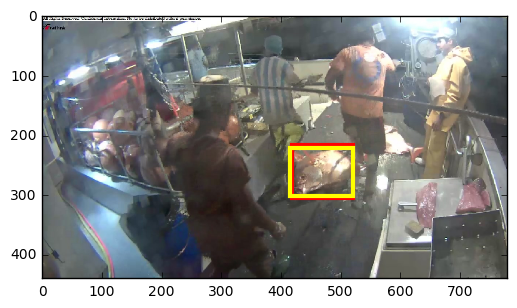

In [16]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    pbb = pval_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb, color='red'))
    plt.gca().add_patch(create_rect(pbb, color='yellow'))

show_bb(350)

In [17]:
# metrics.log_loss(val_labels, do_clip(sum(pvalsls)/len(pvalsls), .9999))
preds = sum(predsls)/len(predsls)
subm = do_clip(preds, clip)

if full:
    subm_name = path+'results/subm_full_conv_' + timestr + 'B.csv' #'.csv.gz'
else:
    subm_name = path+'results/subm_part_conv_' + timestr + 'B.csv' #'.csv.gz'

classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.to_csv(subm_name, index=False)#, compression='gzip')
log.info('Done - files @ ' + subm_name)

[2017-02-18 23:24:30.029553] INFO: Logbook: Done - files @ ../data/fish/results/subm_full_conv_20170218B.csv


In [18]:
FileLink(subm_name)

/home/ubuntu/fish/data/fish/results/subm_full_conv_20170218B.csv